<a href="https://colab.research.google.com/github/thingumajig/colab-experiments/blob/master/RetinaNet_Video_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# .init

## setup keras-retinanet

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

%cd keras-retinanet/
!pip install .

!python setup.py build_ext --inplace

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 4712, done.
remote: Total 4712 (delta 0), reused 0 (delta 0), pack-reused 4712
Receiving objects: 100% (4712/4712), 14.43 MiB | 36.84 MiB/s, done.
Resolving deltas: 100% (3128/3128), done.
/content/keras-retinanet
Processing /content/keras-retinanet
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
b

## download model

In [2]:
#!curl -LJO --output snapshots/pretrained.h5 https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5 

import urllib
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

('./snapshots/_pretrained_model.h5',
 <http.client.HTTPMessage at 0x7f136f42e048>)

# inference

## modules

In [3]:
!pwd
#import os, sys
#sys.path.insert(0, 'keras-retinanet')

 

# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# import keras
import keras

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

/content/keras-retinanet


Using TensorFlow backend.


## load model

In [4]:
# %cd keras-retinanet/
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)
print(os.path.isfile(model_path))

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
# model = models.convert_model(model)


# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 
                   6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 
                   11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 
                   16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 
                   22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 
                   27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 
                   32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 
                   36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 
                   40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 
                   45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 
                   50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 
                   55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 
                   60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 
                   65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 
                   69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 
                   74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 
                   79: 'toothbrush'}

snapshots/_pretrained_model.h5
True
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## detect objects

In [0]:


def img_inference(img_path, threshold_score = 0.8):
  image = read_image_bgr(img_path)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score <  threshold_score:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

processing time:  7.703946113586426


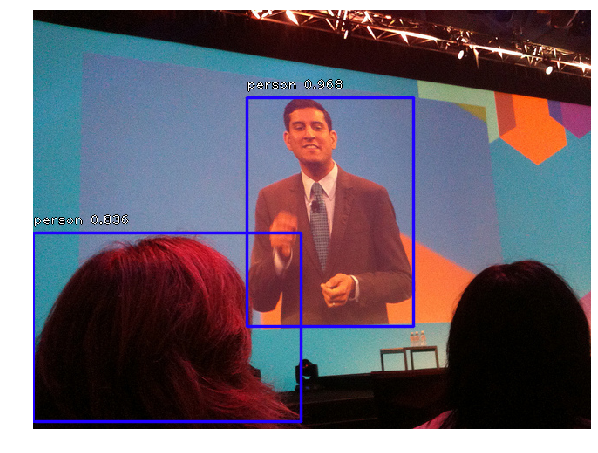

In [6]:
img_inference('examples/000000008021.jpg')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

GPU = get_available_gpus()[-1][0:-1]
print(GPU)

device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.


In [0]:
import glob
 
def create_video(img_path, name ='processed', img_ext = '*.jpg', image_size=(1280, 720)):  
  _name = name + '.mp4'
  #_cap = VideoCapture(0)
  _fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  _out = cv2.VideoWriter(_name, _fourcc, 15.0, image_size)
  
  #   out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
  for filename in sorted(glob.glob(os.path.join(img_path, img_ext))):
    print(filename)
    img = cv2.imread(filename)
    _out.write(img)
    del img
  _out.release()

In [0]:
import unicodedata
import string

valid_filename_chars = f"-_.() {string.ascii_letters}{string.digits}"
char_limit = 255


def clean_filename(filename, whitelist=valid_filename_chars, replace=' '):
  # replace spaces
  for r in replace:
    filename = filename.replace(r, '_')

  # keep only valid ascii chars
  cleaned_filename = unicodedata.normalize('NFKD', filename).encode('ASCII', 'ignore').decode()

  # keep only whitelisted chars
  cleaned_filename = ''.join(c for c in cleaned_filename if c in whitelist)
  if len(cleaned_filename) > char_limit:
    print(f"Warning, filename truncated because it was over {char_limit}. Filenames may no longer be unique")
  return cleaned_filename[:char_limit]    

In [0]:
import colorsys
import random
from tqdm import tqdm

N = len(labels_to_names)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: tuple(255*np.array(colorsys.hsv_to_rgb(*x))), HSV_tuples))
random.shuffle(RGB_tuples)

def object_detect_video(video_path, out_temp_dir='tmp', video_name = 'processed', threshold = 0.6):
  cap = cv2.VideoCapture(video_path)
  
  if not os.path.exists(out_temp_dir):
    os.makedirs(out_temp_dir)

  t = tqdm(total=1, unit="frame(s)")
  
  counter = 0
  sum_time = 0
  video_out = None
  while(True):
      ret, draw = cap.read()
      if not ret:
          break
      bgr = cv2.cvtColor(draw, cv2.COLOR_RGB2BGR)

      # preprocess image for network
      image = preprocess_image(bgr)
      image, scale = resize_image(image)
      
      if counter == 0:
        height, width, channels = draw.shape
        print(f'Shape: {width}X{height}')
        _name = video_name + '.mp4'
        _fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        video_out = cv2.VideoWriter(_name, _fourcc, 20.0, (width, height))
 

      # process image
      start = time.time()      
      boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
      t = time.time() - start
      #print(f"frame:{counter} processing time: {t}")
      t.total += 1
      # fancy way to give info without forcing a refresh
      t.set_postfix(dir=f'frame {counter} time {sum_time}', refresh=False)
      t.update(0)  # may trigger a refresh

      # correct for image scale
      boxes /= scale
      
      # visualize detections
      #draw_detections(image, boxes, scores, labels, color=None, label_to_name=None, score_threshold=0.5)
      
      for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < threshold:
            continue
            

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = f"{labels_to_names[label]} {score:.3f}"
        draw_caption(draw, b, caption)
            
      if sum_time>0:
        cv2.putText(draw, "Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(t,1.0/t,sum_time/counter,counter/sum_time), (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 7)
        cv2.putText(draw, "Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(t,1.0/t,sum_time/counter,counter/sum_time), (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
      
      # cv2.imwrite(os.path.join(out_temp_dir, f'img{counter:08d}.jpg'),draw)
      video_out.write(draw)
      
      counter=counter+1
      sum_time+=t

  cap.release()
  video_out.release()
  cv2.destroyAllWindows()
  t.set_postfix(dir=video_path)
  t.close()

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

  fn0 = clean_filename(fn)
  #with open(fn0, "wb") as df:
  #    df.write(uploaded[fn])
  #    df.close()
      
  object_detect_video(fn, f'{fn0}_tmp', video_name=f'{os.path.basename(fn0)}_processed', threshold = 0.5)
  #create_video(f'{fn0}_tmp')
  files.download(f'{os.path.basename(fn0)}_processed.mp4')
  

Saving Best Shootout Goals Ever.mp4 to Best Shootout Goals Ever.mp4


In [0]:
# object_detect_video('Canada vs. Finland - Gold Medal Game - Game Highlights - IIHFWorlds 2019.mp4', 'video_tmp', video_name = 'processed2')

In [0]:
#sorted(glob.glob('/content/keras-retinanet/video_tmp/*.jpg'))
#create_video('/content/keras-retinanet/video_tmp')
